# California wildfires 2017 - Thomas Fire analysis

The Thomas Fire is a massive wildfire burning in Ventura and Santa Barbara Counties, and one of multiple wildfires that started in early December 2017 in Southern California. It has burned approximately 270,500 acres (423 sq mi; 1,095 km2), becoming the largest wildfire of the 2017 California wildfire season, and the third-largest wildfire in modern California history.

![](thomasfire_cropped.jpg)

In [1]:
from arcgis.gis import *
import pandas as pd

In [2]:
gis = GIS('https://deldev.maps.arcgis.com', 'deldev')

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>
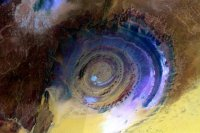

In [3]:
landsat_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

### Select before and after rasters

In [4]:
aoi = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 'type': 'extent', 
       'xmax': -13305000, 'xmin': -13315000, 'ymax': 4106000, 'ymin': 4052000}
landsat.extent = aoi

In [5]:
selected = landsat.filter_by(where="(Category = 1)",
                             geometry=arcgis.geometry.filters.intersects(aoi))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", order_by_fields="AcquisitionDate").df
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df.tail(2)

,AcquisitionDate,CloudCover,DayOfYear,GroupName,OBJECTID,Shape_Area,Shape_Length,SHAPE
76,2017-11-23 18:34:42.440,0.0441,327,LC80420362017327LGN00_MTL,592506,5.131484e+10,906509.716682,"{'rings': [[[-13208036.3849, 4199102.123899996..."
77,2017-12-09 18:34:39.504,0.2136,343,LC80420362017343LGN00_MTL,598449,5.127378e+10,906136.246386,"{'rings': [[[-13208251.4004, 4199098.6241], [-..."


In [6]:
prefire = landsat.filter_by('OBJECTID=592506') # 2017-11-23 
midfire = landsat.filter_by('OBJECTID=598449') # 2017-12-09 

## Visual Assessment

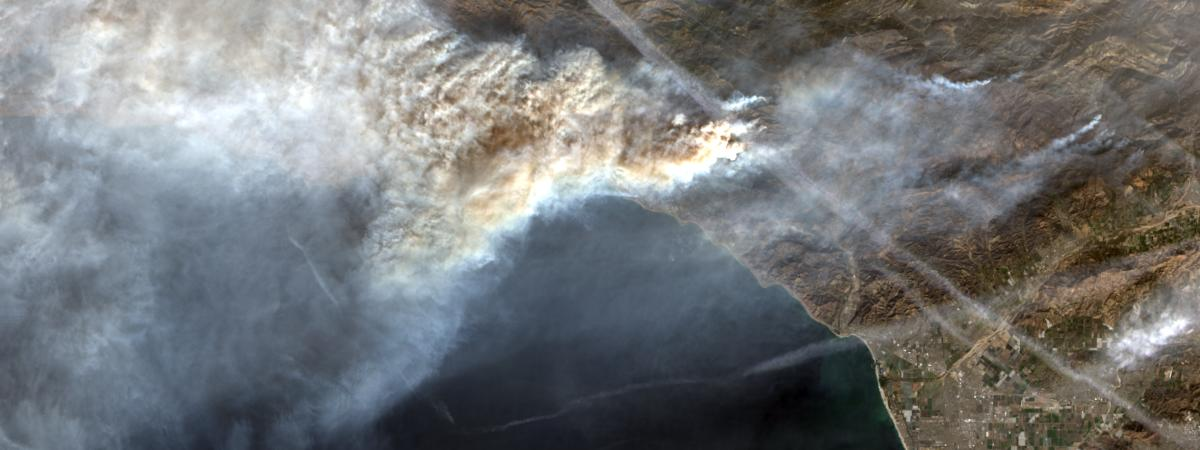

In [7]:
from arcgis.raster.functions import *

apply(midfire, 'Natural Color with DRA')

### Visualize Burn Scars

Extract the [6, 4, 1] bands to improve visibility of fire and burn scars. This band combination pushes further into the SWIR range of the electromagnetic spectrum, where there is less susceptibility to smoke and haze generated by a burning fire.

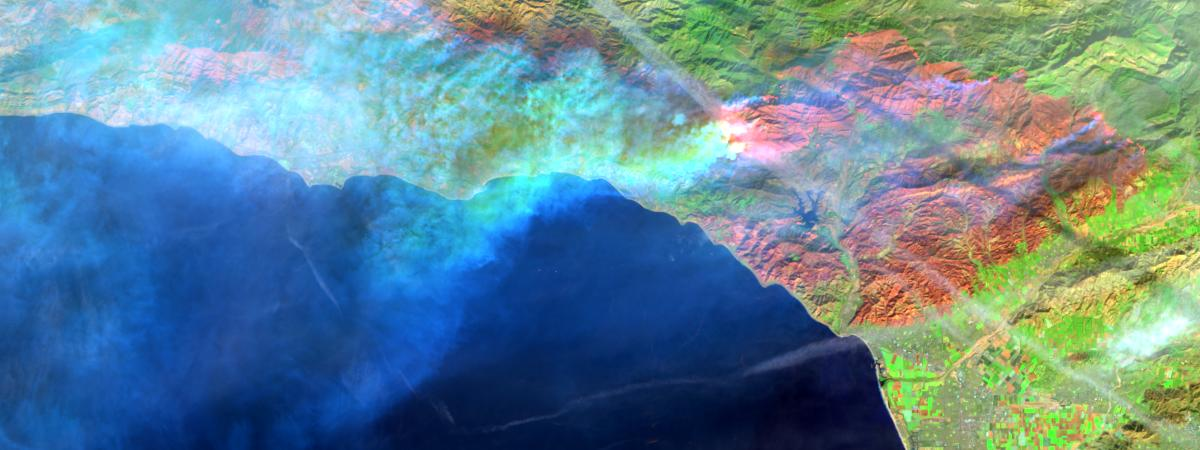

In [8]:
extract_band(midfire, [6,4,1])

For comparison, the same area before the fire started shows no burn scar:

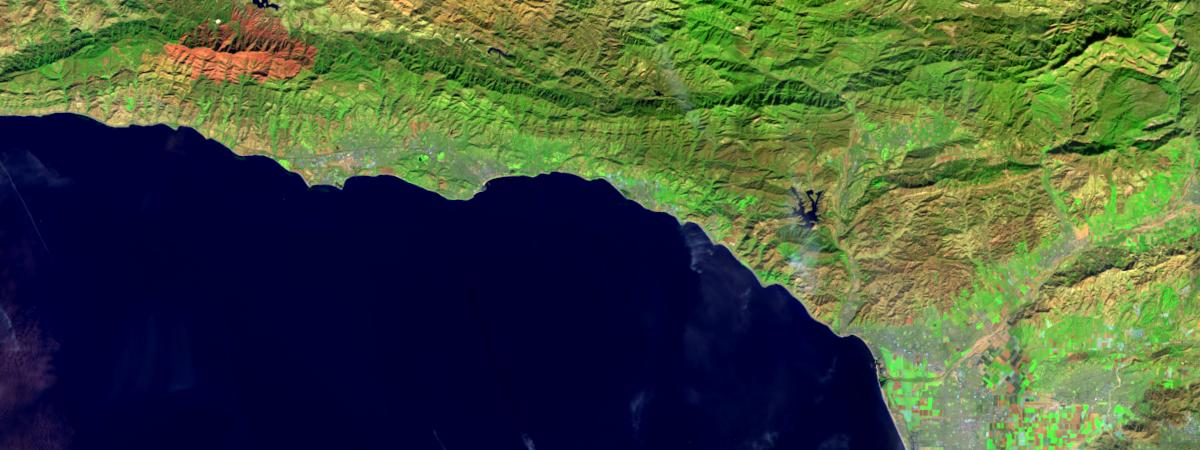

In [9]:
extract_band(prefire, [6,4,1])

## Quantitative Assessment

The **Normalized Burn Ratio (NBR)** was defined to highlight areas that have burned and to index the severity of a burn using Landsat imagery.

The formula for the NBR is very similar to that of NDVI except that it uses near-infrared band 5 and the short-wave infrared band 7:
\begin{align}
{\mathbf{NBR}} = \frac{\mathbf{B_5} - \mathbf{B_7}}{\mathbf{B_5} + \mathbf{B_7}} \\   
\end{align}

The NBR equation was designed to be calcualted from reflectance, but it can be calculated from radiance and digital_number_(dn) with changes to the burn severity table below. 

For a given area, NBR is calculated from an image just prior to the burn and a second NBR is calculated for an image immediately following the burn. Burn extent and severity is judged by taking the difference between these two index layers:

\begin{align}
{\Delta \mathbf{NBR}} = \mathbf{NBR_{prefire}} - \mathbf{NBR_{postfire}} \\   
\end{align}

The meaning of the ∆NBR values can vary by scene, and interpretation in specific instances should always be based on some field assessment. However, the following table from the USGS FireMon program can be useful as a first approximation for interpreting the NBR difference:


| \begin{align}{\Delta \mathbf{NBR}}  \end{align}      | Burn Severity |
| ------------- |:-------------:|
| 0.1 to 0.27   | Low-severity burn |
| 0.27 to 0.44  | Moderate-low severity burn |
| 0.44 to 0.66 | Moderate-high severity burn |
| > 0.66 | High severity burn |

[Source: http://wiki.landscapetoolbox.org/doku.php/remote_sensing_methods:normalized_burn_ratio]

In [10]:
nbr_prefire  = band_arithmetic(prefire, "(b5 - b7) / (b5 + b7)")
nbr_postfire = band_arithmetic(midfire, "(b5 - b7) / (b5 + b7)")

nbr_diff = nbr_prefire - nbr_postfire

In [11]:
mask = remap(nbr_diff,
             input_ranges=[0.1, 0.27, 0.27, 0.44, 0.44, 0.66, 0.66, 1],  # change in NBR
             output_values=[1, 2, 3, 4],                                 # burn severity
             no_data_ranges=[-1, 0.1], astype='u8')

### Compute burnt area

In [12]:
ext = {"xmax": -13246079.10806628, "ymin": 4035733.9433013694, "xmin": -13438700.419344831, "ymax": 4158033.188557592,
       "spatialReference": {"wkid": 102100, "latestWkid": 3857}, "type": "extent"}
pixx = (ext['xmax'] - ext['xmin']) / 1200.0
pixy = (ext['ymax'] - ext['ymin']) / 450.0

In [13]:
res = mask.compute_histograms(ext, pixel_size={'x':pixx, 'y':pixy})
numpix = 0
for i in res['histograms'][0]['counts']:
    numpix += i
    
sqmarea = numpix * pixx * pixy # in sq. m
acres = 0.00024711 * sqmarea   # in acres

print('Thomas fire has consumed {:,} acres till {}.'.format(int(acres), df.iloc[-1]['AcquisitionDate'].date()))

Thomas fire has consumed 229,304 acres till 2017-12-09.


### Visualize burnt areas

In [14]:
burnt_areas = colormap(mask, colormap=[[4, 0xFF, 0xC3, 0],
                            [3, 0xFA, 0x8E, 0],
                            [2, 0xF2, 0x55, 0],
                            [1, 0xE6, 0,    0]])

In [15]:
m = gis.map('Carpinteria, CA', zoomlevel=10)
m

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[34.39152000000007, -119.50831], zoom=10)

![](sample-output.png)

In [16]:
m.add_layer([midfire, burnt_areas])

Compare with current extent of Thomas Fire:

In [17]:
from arcgis.features import FeatureLayer
live_fires = FeatureLayer('https://utility.arcgis.com/usrsvcs/servers/ab338b46b77b4765b0a04e883de77db6/rest/services/LiveFeeds/Wildfire_Activity/MapServer/2')

live_fires_df = live_fires.query().df

In [18]:
m.add_layer(live_fires)

## Impact Assessment

In [19]:
from arcgis.geoenrichment import *

In [20]:
impacted_people = enrich(live_fires_df, 'Age')

In [21]:
thomas_pop = impacted_people[impacted_people.FIRE == 'THOMAS']
thomas_pop

,ACRES,ACTIVE,AGENCY,COMMENTS,DATE_TIME,FEM0,FEM10,FEM15,FEM20,FEM25,...,MALE85,OBJECTID,OBJECTID_0,Shape_Area,Shape_Length,UNIT_ID,YEAR_,aggregationMethod,sourceCountry,SHAPE
1,271990.839206,Y,C&L,Event Standard Perims,1513728000000,227,305,310,321,278,...,119,2,2,1.622441e+09,569690.10979,CAVNC,2017,BlockApportionment:US.BlockGroups,US,"{'rings': [[[-119.3589912639347, 34.5857165073..."


### Visualize using charts

In [22]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 
plt.style.use('ggplot')

sf = thomas_pop.T
sf.reset_index(inplace=True)
sf['age'] = sf['index'].str.extract('(\d+)')

fem = sf[sf['index'].str.startswith('FEM')]
fem.rename(columns={1:'female'}, inplace=True)
fem['age'] = pd.to_numeric(fem['age'])
fem.sort_values(by='age', ascending=False, inplace=True)

male = sf[sf['index'].str.startswith('MALE')]
male.rename(columns={1:'male'}, inplace=True)
male['age'] = pd.to_numeric(male['age'])
male.sort_values(by='age', ascending=False, inplace=True)

popdf = pd.merge(male, fem, on='age')
popdf['agelabel'] = popdf['age'].map(str) + ' - ' + (popdf['age']+4).map(str)
popdf['male'] = -popdf['male']

### Age Pyramid of affected population

In [23]:
print('Number of affected people: ' + str(popdf['female'].sum() - popdf['male'].sum()))

Number of affected people: 11226


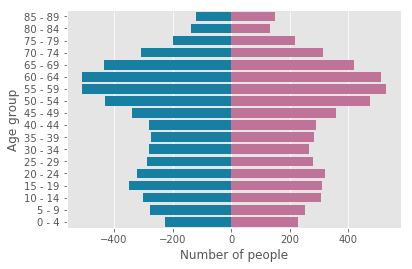

In [24]:
sns.barplot(x="female", y="agelabel", color="#CC6699", label="Female", data=popdf, edgecolor='none')
sns.barplot(x="male",   y="agelabel", color="#008AB8", label="Male",   data=popdf,  edgecolor='none')
plt.ylabel('Age group')
plt.xlabel('Number of people');

![](wildfire_banner.jpg)